In [49]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [50]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    # represent class object as string 
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        # the addition propagates
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other): # other + self
        return self + other

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        # chain rule
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (self.data ** (other - 1)) * other * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        # local derivative
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [51]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [52]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# activation function
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'out'
o.backward()

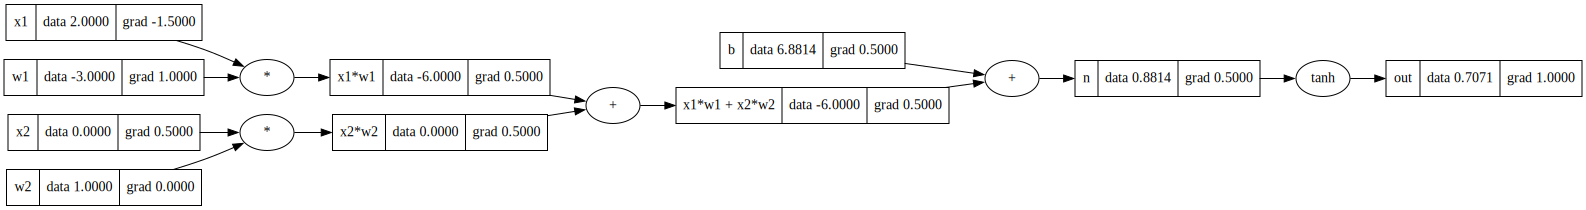

In [53]:
draw_dot(o)

In [54]:
# decomposing tanh

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# activation function
n = x1w1x2w2 + b; n.label = 'n'
# ----- 
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----- 
o.label = 'out'
o.backward()

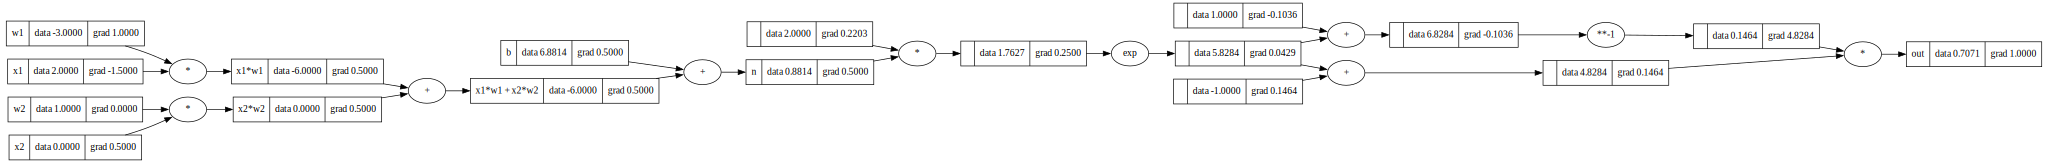

In [55]:
draw_dot(o)

In [56]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        # multiply elements of x and elements of w pair-wise
        activation = sum((wi*xi for wi, xi in zip(self.w , x)), self.b)
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

# a layer is a set of indipendent neurons    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

# Multi Layer Perceptron
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [89]:
# manual network
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.84179508843692)

In [90]:
# examples
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
# desired targets
ys = [1.0, -1.0, -1.0, 1.0]

In [59]:
# loss = how good the network is performing, we have to achieve low loss
# loss = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # mean squared error loss
ypred = [n(x) for x in xs]
total_loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
total_loss

Value(data=5.601005843742109)

In [80]:
# bacward pass
total_loss.backward()

In [81]:
# if the grad is negative his influence on the loss is also negative
# so slightly increasing the weight of the neuron of the layer would make the loss go down

# update
for p in n.parameters():
    p.data += -0.01  * p.grad

In [82]:
# forward pass
ypred = [n(x) for x in xs]
total_loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
total_loss

Value(data=3.5333210236218884)

In [105]:
# forward pass -> backward pass -> update -> network improvement :)

# creating the network
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

# data examples
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
# desired targets
ys = [1.0, -1.0, -1.0, 1.0]

# training
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # resetting the grad, because the backwards pass does a +=
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(k + 1, loss.data)

1 3.737065634233386
2 2.5779117055437206
3 1.546695560780081
4 0.9196856011727705
5 0.6240381470730345
6 0.4772808637684507
7 0.3922728169829063
8 0.3360147423207903
9 0.2951327373888805
10 0.2635368842680159
11 0.23811095360024592
12 0.21708226477433823
13 0.19934785943847969
14 0.18417069446553674
15 0.17103064242475507
16 0.15954532599053084
17 0.14942484932734781
18 0.14044418576418619
19 0.13242539099563946
20 0.12522562112548663


In [106]:
ypred

[Value(data=0.9718462980790952),
 Value(data=-0.7767494204385096),
 Value(data=-0.8169561791915498),
 Value(data=0.797300398167786)]